<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/PatchSeq_Pilot_scAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# !pip install pandas
# !pip install scanpy
# !pip install wget


In [64]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import wget
import gzip
import shutil
import chardet
import matplotlib.pyplot as plt
import requests
import urllib
import re

response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py

In [65]:

# Paths to your files
os.chdir(r'\\hive.gladstone.internal\Huang-Lab\Lab Members\Tabuena\Patch_Seq_RNA_Analysis\pilot_patchseq\analysis_workspace')
counts_file = r"\\hive.gladstone.internal\Huang-Lab\Lab Members\Tabuena\Patch_Seq_RNA_Analysis\pilot_patchseq\counts.STAR.MOUSE.txt"

# Define paths and URLs for the GTF file
gtf_url = 'ftp://ftp.ensembl.org/pub/release-110/gtf/mus_musculus/Mus_musculus.GRCm39.110.gtf.gz'
gtf_file = 'Mus_musculus.GRCm39.110.gtf.gz'


In [66]:
def load_anndata(file_path):
    """
    Load an AnnData object from the specified file path.
    """
    adata = sc.read(file_path)
    return adata


In [67]:
def download_and_decompress_gtf(gtf_url, gtf_file):
    """
    Download the GTF file and decompress it, if not already done.

    Parameters:
    gtf_url (str): The URL to download the GTF file from.
    gtf_file (str): The path where the GTF file (compressed) will be saved.

    Returns:
    str: The path to the decompressed GTF file.
    """
    # Define the decompressed file path
    decompressed_file = gtf_file.replace('.gz', '')

    # Check if the decompressed file already exists
    if not os.path.isfile(decompressed_file):
        # Check if the compressed file already exists
        if not os.path.isfile(gtf_file):
            # Download the GTF file
            wget.download(gtf_url, gtf_file, bar=None)  # `bar=None` to suppress the download progress bar

        # Decompress the GTF file
        with gzip.open(gtf_file, 'rb') as f_in:
            with open(decompressed_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else:
        print(f"{decompressed_file} already exists. Skipping download and decompression.")

    return decompressed_file


def detect_file_encoding(file_path):
    """
    Detect the encoding of a file using chardet.
    """
    with open(file_path, 'rb') as file:
        result = chardet.detect(file.read(10000))
    return result['encoding']

def create_ensembl_to_gene_mapping(gtf_file):
    """
    Create a mapping of Ensembl IDs to gene names from a GTF file, focusing only on coding regions (exons).
    """
    ensembl_to_gene = {}

    with open(gtf_file, 'r', encoding='utf-8', errors='replace') as file:
        for line in file:
            if line.startswith('#'):
                continue
            fields = line.strip().split('\t')
            if len(fields) < 9:
                continue  # skip lines that do not have enough fields
            seqname, source, feature, start, end, score, strand, frame, attributes = fields

            if feature == 'exon':
                # Extract attributes
                attributes_dict = dict(item.split(None, 1) for item in attributes.split('; ') if item)
                ensembl_id = attributes_dict.get('gene_id', '').strip('"')
                gene_name = attributes_dict.get('gene_name', '').strip('"')

                if ensembl_id and gene_name:
                    ensembl_to_gene[ensembl_id.split('.')[0]] = gene_name

    ensembl_df = pd.DataFrame(list(ensembl_to_gene.items()), columns=['Ensembl_ID', 'Gene_Name'])
    ensembl_df.to_csv('ensembl_to_gene_mapping.csv', index=False)

    return ensembl_to_gene, ensembl_df

In [68]:
def add_gene_names_metadata(adata, ensembl_to_gene):
    """
    Add gene names as metadata to the AnnData object.
    """
    gene_names = [ensembl_to_gene.get(gene_id, 'unknown') for gene_id in adata.var_names]
    adata.var['gene_name'] = gene_names
    return adata

In [69]:
def load_coding_genes(csv_file):
    """
    Load coding genes from a CSV file and return a set of gene names.
    """
    coding_df = pd.read_csv(csv_file)
    coding_genes = set(coding_df[coding_df['is_coding'] == True]['external_gene_name'])
    return coding_genes

In [70]:
def filter_noncoding_genes(adata, coding_genes):
    """
    Filter out non-coding genes from the AnnData object.
    """
    is_coding = adata.var['gene_name'].isin(coding_genes)
    filtered_adata = adata[:, is_coding].copy()
    return filtered_adata

In [71]:
def consolidate_counts_by_gene(adata):
    """
    Consolidate counts for genes by summing counts for identical gene names.
    """
    # Convert AnnData to DataFrame
    counts_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var['gene_name'])

    # Consolidate counts by gene
    # Group by gene names (columns), summing counts for each gene
    consolidated_df = counts_df.groupby(counts_df.columns, axis=1).sum()

    # Ensure the new DataFrame has the same index and columns
    consolidated_df = consolidated_df.groupby(consolidated_df.index).sum()

    # Create a new AnnData object with consolidated counts
    # The new var DataFrame should have gene names as its index
    adata_consolidated = sc.AnnData(
        X=consolidated_df.values,
        obs=adata.obs,
        var=pd.DataFrame(index=consolidated_df.columns)
    )

    return adata_consolidated

In [72]:

# Decompress and create the Ensembl to Gene mapping
decompressed_file = download_and_decompress_gtf(gtf_url, gtf_file)

# Load the AnnData object
patchseq_pilot_df = pd.read_csv(counts_file, sep='\t', index_col=0)
patchseq_pilot_adata = sc.AnnData(X=patchseq_pilot_df.values,
                   obs=pd.DataFrame(index=patchseq_pilot_df.index),
                   var=pd.DataFrame(index=patchseq_pilot_df.columns)).T

# Get Ensembl to Gene mapping
ensembl_to_gene, df = create_ensembl_to_gene_mapping(decompressed_file)
# display(df)

# Add gene names as metadata
patchseq_pilot_adata = add_gene_names_metadata(patchseq_pilot_adata, ensembl_to_gene)

# Load coding genes
coding_genes_csv = 'mmusculus_coding_noncoding.csv'
coding_genes = load_coding_genes(coding_genes_csv)
# display(coding_genes)

# Filter out non-coding genes
patchseq_pilot_adata_filt= filter_noncoding_genes(patchseq_pilot_adata, coding_genes)
display(patchseq_pilot_adata_filt)

# Consolidate counts by gene
patchseq_pilot_adata_cons = consolidate_counts_by_gene(patchseq_pilot_adata_filt)
display(patchseq_pilot_adata_cons)

Mus_musculus.GRCm39.110.gtf already exists. Skipping download and decompression.


AnnData object with n_obs × n_vars = 24 × 21470
    var: 'gene_name'

AnnData object with n_obs × n_vars = 24 × 21446

In [73]:
def extract_metadata(cell_name):
    # Define patterns
    genotype_pattern = re.compile(r'-([E3E4]{2})-') # Adjusted pattern for clarity
    age_pattern = re.compile(r'-P(\d+)-')
    age_bin_pattern = re.compile(r'-([OY])-\d+-')  # Updated pattern to match 'O' or 'Y' specifically

    # Default values for special cases
    default_genotype = 'NA'
    default_age = 999
    default_age_bin = 'young'

    # Extract genotype
    genotype_match = genotype_pattern.search(cell_name)
    genotype = genotype_match.group(1) if genotype_match else default_genotype

    # Extract age
    age_match = age_pattern.search(cell_name)
    age = int(age_match.group(1)) if age_match else default_age

    # Extract age bin
    age_bin_match = age_bin_pattern.search(cell_name)
    if age_bin_match:
        age_bin = 'young' if age_bin_match.group(1) == 'Y' else 'old'
    else:
        age_bin = default_age_bin  # Fallback to default if no match

    return genotype, age, age_bin

def update_obs_with_metadata(adata):
    # Extract metadata for each cell
    cell_names = adata.obs.index
    metadata = [extract_metadata(name) for name in cell_names]

    # Create DataFrame from metadata
    metadata_df = pd.DataFrame(metadata, columns=['Genotype', 'Age', 'Age Bin'], index=cell_names)

    # Update obs DataFrame with new columns
    adata.obs['Genotype'] = metadata_df['Genotype']
    adata.obs['Age'] = metadata_df['Age']
    adata.obs['Age Bin'] = metadata_df['Age Bin']

# Example usage
# Assuming 'consolidated_adata_norm' is your AnnData object
update_obs_with_metadata(patchseq_pilot_adata_cons)

# Check updated obs
print(patchseq_pilot_adata_cons.obs.head(24))

                                         Genotype  Age Age Bin
1305-0-E3-O-0215-E3KI-F-P560-s2-c5-DG-29       E3  560     old
1305-0-E3-O-0215-E3KI-F-P560-s2-c6-DG-30       E3  560     old
1305-0-E3-O-0215-E3KI-F-P560-s3-c7-DG-31       E3  560     old
1305-0-E3-O-0215-E3KI-F-P560-s3-c8-DG-32       E3  560     old
1305-0-E3-Y-0427-E3KI-F-P254-s2-c2-DG-72       E3  254   young
1305-0-E4-O-0222-E4KI-F-P590-s1-c1-DG-33       E4  590     old
1305-0-E4-O-0222-E4KI-F-P590-s1-c2-DG-34       E4  590     old
1305-0-E4-O-0222-E4KI-F-P590-s2-c3-DG-35       E4  590     old
1305-0-E4-O-0222-E4KI-F-P590-s2-c4-DG-36       E4  590     old
1305-0-E4-Y-0412-E4KI-F-P236-s3-c6-DG-54       E4  236   young
1305-0-E4-Y-0414-E4KI-F-P238-s2-c2-DG-58       E4  238   young
1305-0-E4-Y-0414-E4KI-F-P238-s2-c3-DG-59       E4  238   young
1305-0-E4-Y-0417-E4KI-F-P241-s1-c1-DG-64       E4  241   young
1305-0-E4-Y-0417-E4KI-F-P241-s1-c2-DG-65       E4  241   young
1305-0-E4-Y-0417-E4KI-F-P241-s1-c3-DG-66       E4  241 

In [74]:
"""
Calculate Mitocondrial Reads
"""
cutoff_pct = 10

# Calculate the percentage of counts from mitochondrial genes
mt_gene_mask = patchseq_pilot_adata_cons.var_names.str.lower().str.startswith('mt-')
mt_counts = patchseq_pilot_adata_cons[:, mt_gene_mask].X.sum(axis=1)
total_counts = patchseq_pilot_adata_cons.X.sum(axis=1)
percent_mt = (mt_counts / total_counts) * 100

patchseq_pilot_adata_cons.obs['mt_counts'] = mt_counts
patchseq_pilot_adata_cons.obs['total_counts'] = total_counts
patchseq_pilot_adata_cons.obs['percent_mt'] = percent_mt

pass_mito_check = patchseq_pilot_adata_cons.obs['percent_mt']<cutoff_pct
patchseq_pilot_adata_qc = patchseq_pilot_adata_cons[pass_mito_check].copy()
patchseq_pilot_adata_qc.obs


"""
Filter By Total Counts
"""
count_range = [200, 50000]
pass_count_check = np.logical_and(patchseq_pilot_adata_qc.obs['total_counts']>np.min(count_range),
                                  patchseq_pilot_adata_qc.obs['total_counts']<np.max(count_range))
patchseq_pilot_adata_qc = patchseq_pilot_adata_qc[pass_count_check]
patchseq_pilot_adata_qc.obs

patchseq_pilot_adata_qc.var.index = patchseq_pilot_adata_qc.var.index.str.upper()

In [226]:
print(patchseq_pilot_adata_qc.obs.head(24))

                                         Genotype  Age Age Bin  mt_counts  \
1305-0-E3-O-0215-E3KI-F-P560-s2-c5-DG-29       E3  560     old          1   
1305-0-E3-O-0215-E3KI-F-P560-s2-c6-DG-30       E3  560     old        216   
1305-0-E3-O-0215-E3KI-F-P560-s3-c7-DG-31       E3  560     old        363   
1305-0-E3-Y-0427-E3KI-F-P254-s2-c2-DG-72       E3  254   young        465   
1305-0-E4-O-0222-E4KI-F-P590-s1-c1-DG-33       E4  590     old        516   
1305-0-E4-O-0222-E4KI-F-P590-s1-c2-DG-34       E4  590     old        802   
1305-0-E4-O-0222-E4KI-F-P590-s2-c3-DG-35       E4  590     old        122   
1305-0-E4-Y-0412-E4KI-F-P236-s3-c6-DG-54       E4  236   young        716   
1305-0-E4-Y-0414-E4KI-F-P238-s2-c2-DG-58       E4  238   young        105   
1305-0-E4-Y-0414-E4KI-F-P238-s2-c3-DG-59       E4  238   young          0   
1305-0-E4-Y-0417-E4KI-F-P241-s1-c1-DG-64       E4  241   young          0   
1305-0-E4-Y-0417-E4KI-F-P241-s1-c2-DG-65       E4  241   young        278   

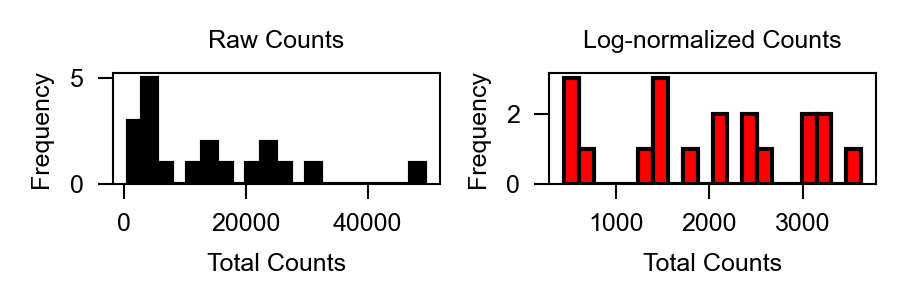

In [84]:
"""
Log & Normalize Counts
"""
patchseq_pilot_adata_norm = patchseq_pilot_adata_qc.copy()

# Normalize the data to total counts per cell
sc.pp.normalize_total(patchseq_pilot_adata_norm, target_sum=1e4)

# Log-transform the normalized data
sc.pp.log1p(patchseq_pilot_adata_norm)

# Extract counts for plotting
raw_counts = patchseq_pilot_adata_qc.X.sum(axis=1).flatten()
log_normalized_counts = patchseq_pilot_adata_norm.X.sum(axis=1).flatten()

fig, ax = plt.subplots(1,2,figsize=(3,1))

# Plot raw counts
ax[0].hist(raw_counts, bins=20, color='k', edgecolor='k')
ax[0].set_title('Raw Counts')
ax[0].set_xlabel('Total Counts')
ax[0].set_ylabel('Frequency')

# Plot log-normalized counts
ax[1].hist(log_normalized_counts, bins=20, color='r', edgecolor='black')
ax[1].set_title('Log-normalized Counts')
ax[1].set_xlabel('Total Counts')
ax[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Save or show the figure
plt.savefig('histograms.png')  # Save as a PNG file
plt.show()  # Display the figure






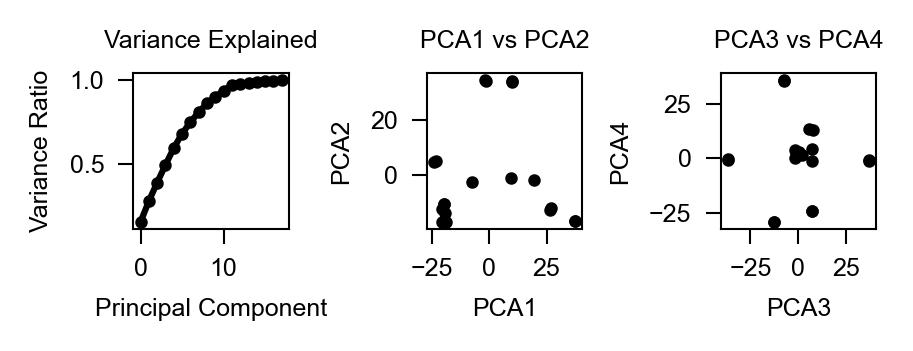

In [85]:
# Run PCA on the normalized and log-transformed data
sc.tl.pca(patchseq_pilot_adata_norm)


# Extract the variance explained
variance_explained = patchseq_pilot_adata_norm.uns['pca']['variance_ratio']
cumulative_variance_explained = np.cumsum(variance_explained)

# Create a 1x3 subplot layout with smaller size
fig, ax = plt.subplots(1, 3, figsize=(3, 1.15), dpi=300)

# Plot variance explained in the first subplot
ax[0].plot(cumulative_variance_explained, marker='.', markersize=4, color='k')
ax[0].set_title('Variance Explained')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Variance Ratio')


# Extract PCA results
pca_result = patchseq_pilot_adata_norm.obsm['X_pca']
pca1 = pca_result[:, 0]
pca2 = pca_result[:, 1]
pca3 = pca_result[:, 2]
pca4 = pca_result[:, 3]


# Plot PCA1 vs PCA2
ax[1].scatter(pca1, pca2, s=4, color='black')
ax[1].set_title('PCA1 vs PCA2')
ax[1].set_xlabel('PCA1')
ax[1].set_ylabel('PCA2')

# Plot PCA3 vs PCA4
ax[2].scatter(pca3, pca4, s=4, color='black')
ax[2].set_title('PCA3 vs PCA4')
ax[2].set_xlabel('PCA3')
ax[2].set_ylabel('PCA4')


# Adjust layout
plt.tight_layout()

# Save or show the figure
# plt.savefig('pca_plots.png')  # Save as a PNG file
plt.show()  # Display the figure

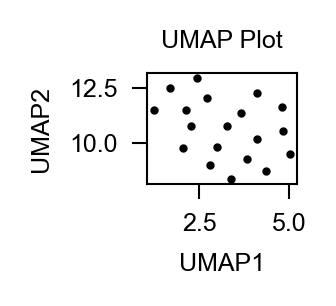

In [86]:
# Run UMAP on the normalized and log-transformed data
sc.pp.neighbors(patchseq_pilot_adata_norm)
sc.tl.umap(patchseq_pilot_adata_norm)

# Extract UMAP results
umap_result = patchseq_pilot_adata_norm.obsm['X_umap']
umap1 = umap_result[:, 0]
umap2 = umap_result[:, 1]

# Create a UMAP plot
plt.figure(figsize=(1, 1), dpi=300)  # 1/4 of the initially planned size
plt.scatter(umap1, umap2, s=1, color='black')  # Adjust color and marker size as needed
plt.title('UMAP Plot')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()

# Save or show the figure
plt.savefig('umap_plot.png')  # Save as a PNG file
plt.show()  # Display the figure


['E3' 'E4' 'NA']
['old' 'young']


C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_22504\565173083.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


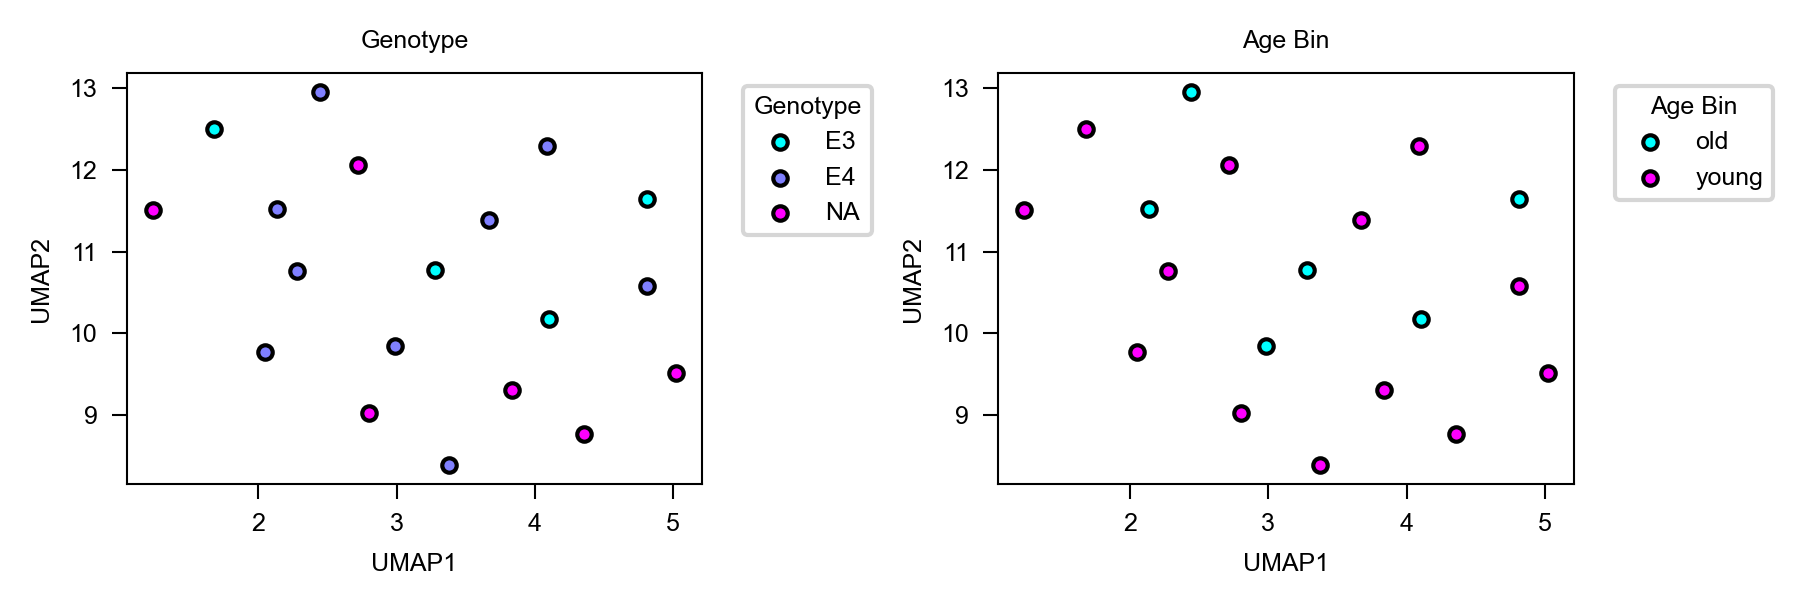

In [218]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Define the metadata columns to plot, excluding 'Age'
categories_to_plot = ['Genotype', 'Age Bin']

# Create figure and axis
fig, ax = plt.subplots(nrows=1, ncols=len(categories_to_plot), figsize=(6, 2), constrained_layout=True)

# Loop through metadata columns to plot UMAP
for i, category in enumerate(categories_to_plot):
    # Extract UMAP coordinates and metadata
    umap1 = patchseq_pilot_adata_norm.obsm['X_umap'][:, 0]
    umap2 = patchseq_pilot_adata_norm.obsm['X_umap'][:, 1]
    metadata = patchseq_pilot_adata_norm.obs[category].astype(str)

    # Create color map
    unique_values = metadata.unique()
    print(unique_values)
    cmap = plt.get_cmap('cool', len(unique_values))
    color_map = {value: cmap(i) for i, value in enumerate(unique_values)}
    colors = metadata.map(color_map)

    # Plot UMAP with color coding
    scatter = ax[i].scatter(umap1, umap2, c=colors, s=4, edgecolor='none')

    # Create legend by plotting each category value
    for value in unique_values:
        mask = metadata == value
        ax[i].scatter(umap1[mask], umap2[mask], c=[color_map[value]], s=12, edgecolor='k', label=value)

    # Add legend and title
    ax[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), title=category)

    # Set axis labels and title
    ax[i].set_title(category)
    ax[i].set_xlabel('UMAP1')
    ax[i].set_ylabel('UMAP2')

# Adjust layout to accommodate the legend outside the plots
plt.tight_layout()
plt.savefig('umap_metadata_plots.png', bbox_inches='tight')  # Save as PNG file
plt.show()


In [88]:
# Perform Louvain clustering
sc.tl.louvain(patchseq_pilot_adata_norm, resolution=1.0)

# Perform differential expression testing
sc.tl.rank_genes_groups(patchseq_pilot_adata_norm, 'louvain', method='t-test')  # 't-test' is the method; alternatives include 'wilcoxon' and 'logreg'

patchseq_pilot_adata_norm

AnnData object with n_obs × n_vars = 19 × 21446
    obs: 'Genotype', 'Age', 'Age Bin', 'mt_counts', 'total_counts', 'percent_mt', 'louvain'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [91]:
pd.DataFrame(patch_seq_GDH_norm.var_names).to_csv('var_names.csv')

In [94]:
# Create a copy of the AnnData object
patch_seq_GDH_norm = patchseq_pilot_adata_norm.copy()
# HGNC (GAPDH)

# Ensure 'GAPDH' is present in the AnnData object
if 'GAPDH' not in patch_seq_GDH_norm.var_names:
    raise ValueError("GAPDH gene not found in the AnnData object.")

# Extract GAPDH counts
gapdh_counts = patch_seq_GDH_norm[:, 'GAPDH'].X
print(gapdh_counts)

[[3.5163682 ]
 [3.3436532 ]
 [2.957865  ]
 [2.941821  ]
 [2.7912652 ]
 [0.80216545]
 [0.        ]
 [0.6655151 ]
 [0.        ]
 [0.        ]
 [3.6284714 ]
 [3.3392308 ]
 [2.8235407 ]
 [3.0904222 ]
 [2.4621909 ]
 [2.600674  ]
 [0.        ]
 [0.        ]
 [0.        ]]


In [ ]:
import scanpy as sc
import numpy as np

# Create a copy of the AnnData object
patch_seq_GDH_norm = patchseq_pilot_adata_norm.copy()

# Ensure 'GAPDH' is present in the AnnData object
if 'GAPDH' not in patch_seq_GDH_norm.var_names:
    raise ValueError("GAPDH gene not found in the AnnData object.")

# Extract GAPDH counts for each cell
gapdh_counts = patch_seq_GDH_norm[:, 'GAPDH'].X

# Convert GAPDH counts to a dense array if they are in a sparse format
if hasattr(gapdh_counts, 'toarray'):
    gapdh_counts = gapdh_counts.toarray()

# Normalize each cell's gene counts by its GAPDH count
# Handle zero GAPDH counts to avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_counts = patch_seq_GDH_norm.X / gapdh_counts

# Replace the old counts with the normalized counts
patch_seq_GDH_norm.X = normalized_counts

# Save the normalized AnnData object if needed
# patch_seq_GDH_norm.write('patch_seq_GDH_norm.h5ad')
patch_seq_GDH_norm[:, 'GAPDH'].X




In [ ]:
data_normalized = patch_seq_GDH_norm.X
gene_sums = np.sum(data_normalized, axis=0)
gene_names = patch_seq_GDH_norm.var_names
gene_counts_df = pd.DataFrame({
    'gene': gene_names,
    'total_counts': gene_sums
})
gene_counts_df = gene_counts_df.sort_values(by='total_counts', ascending=False)
gene_counts_df

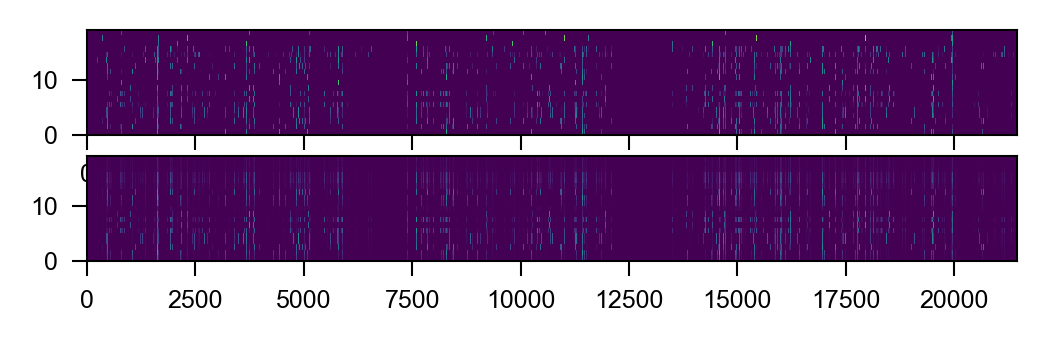

In [148]:
"""
Gene Imputation
"""
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.impute import SimpleImputer

# Create a copy of the AnnData object
imputed_adata = patchseq_pilot_adata_norm.copy()

# Extract the data matrix
data = imputed_adata.X

# Perform NMF
nmf = NMF(n_components=5, init='random', random_state=42)
nmf_data = nmf.fit_transform(data)
reconstructed_data = np.dot(nmf_data, nmf.components_)

fig,ax=plt.subplots(2,1,figsize=(4,1))
ax[0].pcolormesh(data)
ax[1].pcolormesh(reconstructed_data)

imputed_adata.X = reconstructed_data
gapdh_counts = imputed_adata[:, 'GAPDH'].X


In [227]:
# Create a copy of the AnnData object
patch_seq_GDH_norm = imputed_adata.copy()

# Ensure 'GAPDH' is present in the AnnData object
if 'GAPDH' not in patch_seq_GDH_norm.var_names:
    raise ValueError("GAPDH gene not found in the AnnData object.")

# Extract GAPDH counts for each cell
gapdh_counts = patch_seq_GDH_norm[:, 'GAPDH'].X

# Convert GAPDH counts to a dense array if they are in a sparse format
if hasattr(gapdh_counts, 'toarray'):
    gapdh_counts = gapdh_counts.toarray()

# Normalize each cell's gene counts by its GAPDH count
# Handle zero GAPDH counts to avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_counts = patch_seq_GDH_norm.X / gapdh_counts

# Replace the old counts with the normalized counts
patch_seq_GDH_norm.X = normalized_counts

# Save the normalized AnnData object if needed
# patch_seq_GDH_norm.write('patch_seq_GDH_norm.h5ad')
# patch_seq_GDH_norm[:, 'GAPDH'].X



In [228]:
# Calculate the mean expression for each gene
mean_expressions = np.mean(patch_seq_GDH_norm.X, axis=0)

# Create a DataFrame to hold gene names and their mean expressions
genes_df = pd.DataFrame({
    'Gene': patch_seq_GDH_norm.var_names,
    'Mean Expression': mean_expressions
})
top_genes_df = genes_df.sort_values(by='Mean Expression', ascending=False)
# display(top_genes_df.head(20))

Text(0.5, 1.0, 'Selec Gene Expression \n rel. GAPDH')

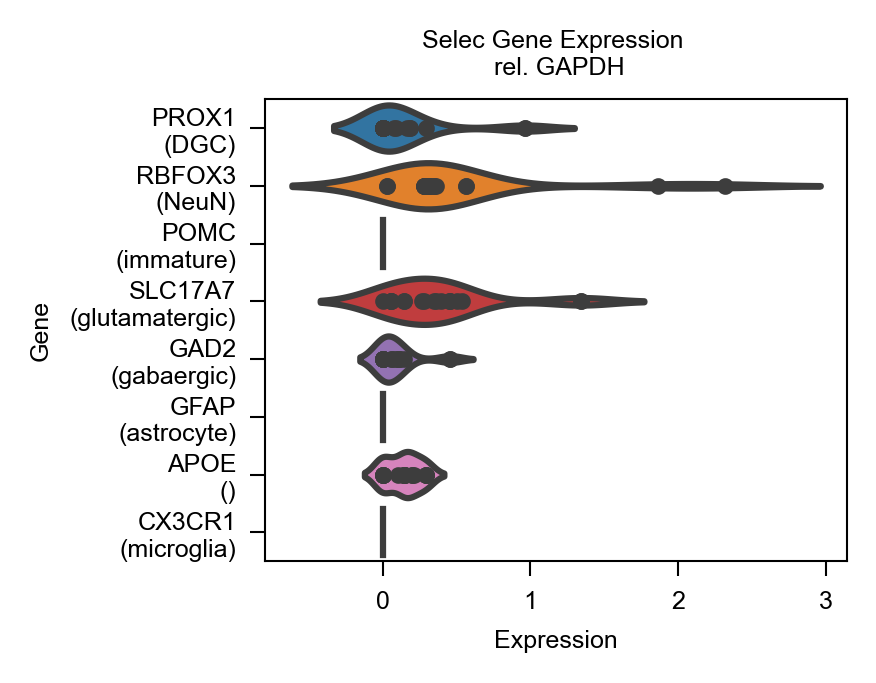

In [224]:
import seaborn as sns
# Define genes_of_interest dictionary
genes_of_interest = {
    'PROX1': 'DGC',
    'RBFOX3': 'NeuN',
    'POMC': 'immature',
    'SLC17A7': 'glutamatergic',
    'GAD2': 'gabaergic',
    'GFAP': 'astrocyte',
    'APOE': '',
    'CX3CR1':'microglia'
}

# Extract the expression matrix for the genes of interest
genes = list(genes_of_interest.keys())
expression_matrix = patch_seq_GDH_norm[:, genes].X

# Convert the expression matrix to a DataFrame
expression_df = pd.DataFrame(expression_matrix, columns=genes, index=patch_seq_GDH_norm.obs.index)

# Add metadata if needed
expression_df['Cell'] = expression_df.index

expression_df.head()

melted_df = expression_df.melt(id_vars='Cell', var_name='Gene', value_name='Expression')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(2.5, 2))  # Adjust size as needed

# Plot with seaborn
sns.violinplot(data=melted_df, y='Gene', x='Expression',  orient='h',scale='width', inner='point')
tics = ax.get_yticks()
ytick_labels = [label.get_text() for label in ax.get_yticklabels()]
modified_labels = [f"{label}\n({genes_of_interest.get(label, label)})" for label in ytick_labels]
ax.set_yticklabels(modified_labels)
ax.set_title('Selec Gene Expression \n rel. GAPDH')